# Lesson2 畳み込みニューラルネットワーク (CNN)

## 目次

- Section1 解説
  - 1.1 CNN基礎
  - 1.2 Convolution(畳み込み)層
  - 1.3 Pooling(プーリング)層
  - 1.4 確認問題
- Section2 実装①
  - 2.1 Fasion MNISTをCNNでクラス分類
  - 2.2 CIFAR10のデータをCNNでクラス分類
- Section3 テクニック・発展内容
  - 3.1 Data Augmentation
  - 3.2 画像データの正規化
  - 3.3 Batch Normalization
  - 3.4 Skip Connection  (Residual Network)
  - 3.5 学習済みネットワークの利用
  - 3.6 学習させたモデルの保存・再利用
  - 3.7 確認問題
- Section4 実装②
  - 4.1 CIFAR10のデータをCNNでクラス分類②
- Section5 ケーススタディ

## 3.7 の解答

問1: ② 問2: ① 問3: ① 問4: ①

In [1]:
%matplotlib inline

import os

import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Input, Activation, add, Add, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot
from tensorflow.keras.preprocessing.image import ImageDataGenerator

random_state = 42

/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

## Section4 実装②

### 4.1 CIFAR10のデータをCNNでクラス分類②
CIFAR10データセットは次に示す5つのクラスのいずれかに分類される画像データのデータセットである. trainデータが60000件, testデータが10000件の合計60000件からなるデータセットで, 各クラスについて6000枚の画像がある.

- airplane
- automobile
- bird
- cat
- deer
- dog
- frog
- ship
- truck

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32') / 255
y_train = np.eye(10)[y_train.astype('int32').flatten()]

x_test = x_test.astype('float32') / 255
y_test = np.eye(10)[y_test.astype('int32').flatten()]

x_train, x_valid, y_train, y_valid = train_test_split(
    x_train, y_train, test_size=10000)

Section3の学習内容も踏まえて、CIFAR10のクラス分類を行いたいと思います。

まず、モデルの作成を行います。

In [3]:
model = Sequential()

model.add(Conv2D(6, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal', input_shape=(32, 32, 3)))  # 32x32x3 -> 28x28x6
model.add(MaxPooling2D(pool_size=(2, 2)))  # 28x28x6 -> 14x14x6
model.add(Conv2D(16, kernel_size=(5, 5), activation='relu',
                 kernel_initializer='he_normal'))  # 14x14x6 -> 10x10x16
model.add(MaxPooling2D(pool_size=(2, 2)))  # 10x10x16 -> 5x5x16

model.add(Flatten())  # 5x5x16 -> 400
model.add(Dense(120, activation='relu',
                kernel_initializer='he_normal'))  # 400 ->120
model.add(Dense(84, activation='relu', kernel_initializer='he_normal'))  # 120 ->84
model.add(Dense(10, activation='softmax'))  # 84 ->10

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer='adam',
    metrics=['accuracy']
)

Instructions for updating:
Colocations handled automatically by placer.


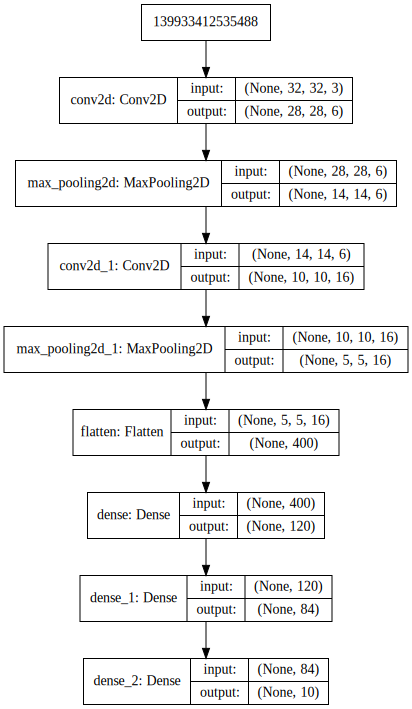

In [5]:
# モデルmodelを可視化
from IPython.display import SVG
from tensorflow.python.keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

次に、Section3で学習したDataAugumentationや画像データの正規化を学習に反映させてみます。

kerasのImageDataGeneratorを使用します。

In [6]:
datagen = ImageDataGenerator(
    width_shift_range=0.2,  # 3.1.1 左右にずらす
    height_shift_range=0.2,  # 3.1.2 上下にずらす
    horizontal_flip=True,  # 3.1.3 左右反転
    # 3.2.1 Global Contrast Normalization (GCN) (Falseに設定しているのでここでは使用していない)
    samplewise_center=False,
    samplewise_std_normalization=False,
    zca_whitening=False)  # 3.2.2 Zero-phase Component Analysis (ZCA) Whitening (Falseに設定しているのでここでは使用していない)

In [8]:
history = model.fit_generator(datagen.flow(x_train, y_train, batch_size=100),
                    steps_per_epoch=x_train.shape[0] // 100, epochs=30, validation_data=(x_valid, y_valid))

Epoch 1/30
400/400 [==============================] - 14s 35ms/step - loss: 1.1929 - acc: 0.5755 - val_loss: 1.1244 - val_acc: 0.6069
Epoch 2/30
400/400 [==============================] - 14s 35ms/step - loss: 1.1898 - acc: 0.5766 - val_loss: 1.1037 - val_acc: 0.6094
Epoch 3/30
400/400 [==============================] - 14s 35ms/step - loss: 1.1814 - acc: 0.5792 - val_loss: 1.0982 - val_acc: 0.6078
Epoch 4/30
400/400 [==============================] - 14s 34ms/step - loss: 1.1789 - acc: 0.5803 - val_loss: 1.2007 - val_acc: 0.5758
Epoch 5/30
400/400 [==============================] - 14s 34ms/step - loss: 1.1796 - acc: 0.5815 - val_loss: 1.2426 - val_acc: 0.5675
Epoch 6/30
400/400 [==============================] - 14s 34ms/step - loss: 1.1700 - acc: 0.5828 - val_loss: 1.1115 - val_acc: 0.6054
Epoch 7/30
400/400 [==============================] - 14s 34ms/step - loss: 1.1682 - acc: 0.5850 - val_loss: 1.1084 - val_acc: 0.6099
Epoch 8/30
400/400 [==============================] - 14s 34ms

In [9]:
# モデルの評価
scores = model.evaluate(x_train, y_train, batch_size=100)

40000/40000 [==============================] - 3s 72us/sample - loss: 0.9620 - acc: 0.6600


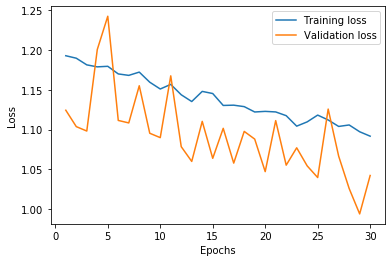

In [11]:
# 損失関数の履歴を取得
loss_train = history.history["loss"]
loss_val = history.history["val_loss"]

# 損失関数をプロット
epochs=range(1,31)
plt.figure(facecolor="white")
plt.plot(epochs,loss_train,label="Training loss")
plt.plot(epochs,loss_val,label="Validation loss")
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

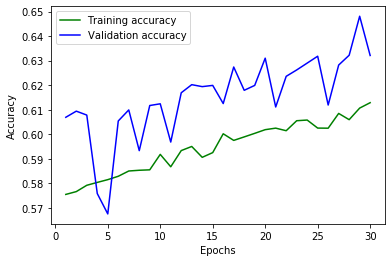

In [12]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,31)
plt.figure(facecolor="white")
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='Validation accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()